<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Reseau_GRU_Avec_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce carnet nous allons mettre en place un modèle à réseau de neurones récurrent de type GRU associé à une couche d'attention pour réaliser des prédictions sur notre série temporelle.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Création de la série temporelle et du dataset pour l'entrainement

In [2]:
# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...Xn) / Y(Y1,Y2,...,Yn)
# X sont les données d'entrées du réseau
# Y sont les labels

def prepare_dataset_XY(serie, taille_fenetre, batch_size, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.shuffle(buffer_melange).map(lambda x: (x[:-1], x[-1:]))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset


# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit)

temps_separation = 1000

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

# Exctraction des temps et des données de valiadation
temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 20
batch_size = 32
buffer_melange = 1000

# Création du dataset X,Y
dataset = prepare_dataset_XY(serie,taille_fenetre,batch_size,buffer_melange)

# Création du dataset X,Y de validation
dataset_Val = prepare_dataset_XY(x_validation,taille_fenetre,batch_size,buffer_melange)

# Création du modèle GRU avec couche d'attention personnalisée

**1. Création du réseau et adaptation des formats d'entrée et de sortie**

Sous forme de shéma, notre réseau est donc le suivant :


<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/LSTM_1.png?raw=true" width="1200"> 

In [ ]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()

On créé une classe dérivée de la classe [Layer](https://keras.io/api/layers/base_layer/#layer-class) de Keras. Les méthodes utilisées sont les suivantes :  
 - [build](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#build) : Permet de créer les variables utilisées par la couche (commes les poids et les offsets)
 - [call](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#call) : Permet d'implanter la logique de la couche

In [259]:
# Importe le Backend de Keras
from keras import backend as K

# Définit une nouvelle classe Couche_Attention
# Héritée de la classe Layer de Keras

class Couche_Attention(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  def __init__(self):
    super().__init__()          # Appel du __init__() de la classe Layer
  
  # Fonction appellée pour créer les variables de la couche
  # input_shape = (nbr_v, dim)
  #     dim   : Dimension des vecteurs cachés de la couche récurrente
  #     nbr_v : Nombre de vecteurs cachés passés à la couche d'attention
  def build(self,input_shape):
    self.dim = input_shape[2]         # Dimension des vecteurs cachés de la couche récurrente
    self.nbr_v = input_shape[1]       # Nombre de vecteurs cachés passés à la couche d'attention
    self.w = self.add_weight(shape=(self.dim,1), initializer="normal", name="w")         # Initialise les poids avec une loi normale
    self.b = self.add_weight(shape=(self.nbr_v,1), initializer="zeros", name="b")        # Initialise les offsets à zéro
    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche d'attention
  # Arguments :   x : Tenseur d'entrée de dimension (None, nbr_v,dim)
  def call(self,x):
    e = K.tanh(K.dot(x,self.w) + self.b)
    a = K.softmax(e,axis=1)                     # Poids d'attention
    sortie = K.sum(x*a, axis=1)                 # Vecteur d'état de sortie d'attention
    return a, sortie


In [255]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()

In [260]:
# Couche d'attention perso

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Fonction dela couche lambda de sortie
def Traitement_Sorties(x):
  return(x*100.0)

# Fonction dela couche lambda de sortie
def Traitement_Sorties(x):
  return(x*100.0)

inputs = tf.keras.Input(shape=(20,))
encoder_output = tf.keras.layers.GRU(units=40,return_sequences=True)(tf.keras.layers.Lambda(Traitement_Entrees)(inputs))
print(encoder_output.shape)
print(hidden_state.shape)

poids_attention, vecteur_attention = Couche_Attention()(encoder_output)
print(poids_attention.shape)
print(vecteur_attention.shape)

outputs = tf.keras.layers.Dense(1,trainable=True)(vecteur_attention)
print(outputs.shape)
out = tf.keras.layers.Lambda(Traitement_Sorties)(outputs)
model=tf.keras.Model(inputs,outputs)

model.summary()

(None, 20, 40)
(None, 40)
(None, 20, 1)
(None, 40)
(None, 1)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 20, 1)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 20, 40)            5160      
_________________________________________________________________
couche__attention_1 (Couche_ ((None, 20, 1), (None, 40 60        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 5,261
Trainable params: 5,261
Non-trainable params: 0
_________________________________________________________________


In [250]:
del model

In [261]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Epoch 1/100
45/45 [==============================] - 2s 7ms/step - loss: 82.3297 - mae: 82.8286

Epoch 00001: loss improved from inf to 89.80927, saving model to poids.hdf5
Epoch 2/100
45/45 [==============================] - 0s 7ms/step - loss: 84.2754 - mae: 84.7750

Epoch 00002: loss improved from 89.80927 to 89.80924, saving model to poids.hdf5
Epoch 3/100
45/45 [==============================] - 0s 8ms/step - loss: 83.9615 - mae: 84.4608

Epoch 00003: loss improved from 89.80924 to 89.80919, saving model to poids.hdf5
Epoch 4/100
45/45 [==============================] - 0s 8ms/step - loss: 84.0332 - mae: 84.5322

Epoch 00004: loss improved from 89.80919 to 89.80911, saving model to poids.hdf5
Epoch 5/100
45/45 [==============================] - 0s 8ms/step - loss: 83.2975 - mae: 83.7971

Epoch 00005: loss improved from 89.80911 to 89.80901, saving model to poids.hdf5
Epoch 6/100
45/45 [==============================] - 0s 8ms/step - loss: 83.5197 - mae: 84.0189

Epoch 00006: loss 

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

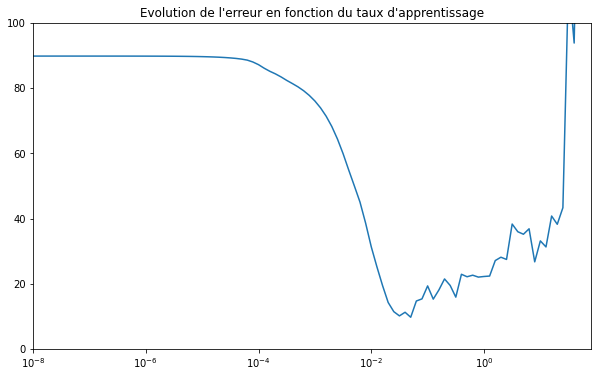

In [262]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 100])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [266]:
# Charge les meilleurs poids
model.load_weights("poids.hdf5")

In [267]:
# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(lr=1.1e-2)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset,validation_data=dataset_Val, epochs=500,verbose=1, callbacks=[CheckPoint])

Epoch 1/500
45/45 [==============================] - 3s 20ms/step - loss: 10.3021 - mae: 10.7932 - val_loss: 18.9585 - val_mae: 19.4505

Epoch 00001: loss improved from inf to 10.85681, saving model to poids.hdf5
Epoch 2/500
45/45 [==============================] - 1s 11ms/step - loss: 7.6436 - mae: 8.1255 - val_loss: 12.7128 - val_mae: 13.2051

Epoch 00002: loss improved from 10.85681 to 8.26850, saving model to poids.hdf5
Epoch 3/500
45/45 [==============================] - 1s 11ms/step - loss: 6.1084 - mae: 6.5919 - val_loss: 8.0400 - val_mae: 8.5279

Epoch 00003: loss improved from 8.26850 to 6.46420, saving model to poids.hdf5
Epoch 4/500
45/45 [==============================] - 1s 12ms/step - loss: 5.0788 - mae: 5.5573 - val_loss: 5.7782 - val_mae: 6.2510

Epoch 00004: loss improved from 6.46420 to 5.45002, saving model to poids.hdf5
Epoch 5/500
45/45 [==============================] - 1s 11ms/step - loss: 5.2693 - mae: 5.7498 - val_loss: 5.3226 - val_mae: 5.8009

Epoch 00005: lo

KeyboardInterrupt: ignored

# Création du modèle GRU avec couche d'attention

In [268]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()

In [269]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/uzaymacar/attention-mechanisms/master/layers.py

--2021-03-10 20:18:09--  https://raw.githubusercontent.com/uzaymacar/attention-mechanisms/master/layers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21419 (21K) [text/plain]
Saving to: ‘layers.py’

layers.py           100%[===================>]  20.92K  --.-KB/s    in 0.001s  

2021-03-10 20:18:09 (18.8 MB/s) - ‘layers.py’ saved [21419/21419]



In [271]:
# Self attention

from layers import SelfAttention

# Fonction dela couche lambda de sortie
def Traitement_Sorties(x):
  return(x*100.0)


inputs = tf.keras.Input(batch_shape=(None,None,1))

encoder_output, hidden_state =tf.keras.layers.GRU(units=40,return_sequences=True,return_state=True)(inputs)

attention_input = [encoder_output, hidden_state]
encoder_output, attention_weights = SelfAttention(size=20,num_hops=16,use_penalization=False)(encoder_output)

outputs = tf.keras.layers.Dense(1,trainable=True)(encoder_output)

out = tf.keras.layers.Lambda(Traitement_Sorties)(outputs)
model=tf.keras.Model(inputs,outputs)

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
gru_1 (GRU)                  [(None, None, 40), (None, 5160      
_________________________________________________________________
self_attention (SelfAttentio ((None, 640), (None, 16,  1120      
_________________________________________________________________
dense (Dense)                (None, 1)                 641       
Total params: 6,921
Trainable params: 6,921
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Global attention

from layers import Attention, SelfAttention

# Fonction dela couche lambda de sortie
def Traitement_Sorties(x):
  return(x*100.0)


inputs = tf.keras.Input(batch_shape=(None,None,1))
encoder_output, hidden_state, cell_stat =tf.keras.layers.LSTM(units=40,return_sequences=True,return_state=True)(inputs)

attention_input = [encoder_output, hidden_state]

encoder_output, attention_weights = Attention(context='many-to-one',alignment_type='global')(attention_input)
outputs = tf.keras.layers.Dense(1,trainable=True)(encoder_output)

out = tf.keras.layers.Lambda(Traitement_Sorties)(outputs)
model=tf.keras.Model(inputs,outputs)

model.summary()


In [ ]:
# Local p* attention

from layers import Attention, SelfAttention

# Fonction dela couche lambda de sortie
def Traitement_Sorties(x):
  return(x*100.0)


inputs = tf.keras.Input(batch_shape=(None,taille_fenetre,1))
encoder_output, hidden_state, cell_stat =tf.keras.layers.LSTM(units=40,return_sequences=True,return_state=True)(inputs)

attention_input = [encoder_output, hidden_state]

encoder_output, attention_weights = Attention(context='many-to-one', alignment_type='local-p*', window_width=taille_fenetre)(attention_input)

outputs = tf.keras.layers.Dense(1,trainable=True)(encoder_output)

out = tf.keras.layers.Lambda(Traitement_Sorties)(outputs)

model=tf.keras.Model(inputs,outputs)

model.summary()

**2. Optimisation du taux d'apprentissage**

In [ ]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()


In [ ]:
del model

In [272]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Epoch 1/100
45/45 [==============================] - 3s 11ms/step - loss: 83.3054 - mae: 83.8045

Epoch 00001: loss improved from inf to 89.40653, saving model to poids.hdf5
Epoch 2/100
45/45 [==============================] - 1s 12ms/step - loss: 82.4757 - mae: 82.9749

Epoch 00002: loss improved from 89.40653 to 89.40632, saving model to poids.hdf5
Epoch 3/100
45/45 [==============================] - 1s 12ms/step - loss: 81.8230 - mae: 82.3220

Epoch 00003: loss improved from 89.40632 to 89.40604, saving model to poids.hdf5
Epoch 4/100
45/45 [==============================] - 1s 12ms/step - loss: 82.6198 - mae: 83.1193

Epoch 00004: loss improved from 89.40604 to 89.40569, saving model to poids.hdf5
Epoch 5/100
45/45 [==============================] - 1s 12ms/step - loss: 81.8987 - mae: 82.3985

Epoch 00005: loss improved from 89.40569 to 89.40523, saving model to poids.hdf5
Epoch 6/100
45/45 [==============================] - 1s 12ms/step - loss: 83.5502 - mae: 84.0493

Epoch 00006:

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

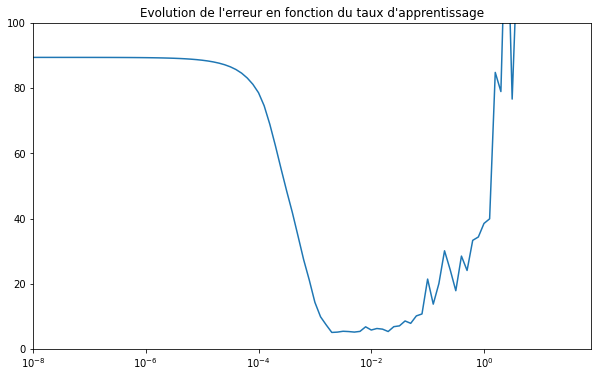

In [273]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 100])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**3. Entrainement du modèle**

In [ ]:
# Remise à zéro des états du modèle
tf.keras.backend.clear_session()

In [274]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [276]:
# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(lr=2e-3)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset,validation_data=dataset_Val, epochs=500,verbose=1, callbacks=[CheckPoint])

Epoch 1/500
45/45 [==============================] - 3s 27ms/step - loss: 4.8023 - mae: 5.2820 - val_loss: 3.9629 - val_mae: 4.4353

Epoch 00001: loss improved from inf to 4.60916, saving model to poids.hdf5
Epoch 2/500
45/45 [==============================] - 1s 16ms/step - loss: 4.4959 - mae: 4.9717 - val_loss: 4.1067 - val_mae: 4.5823

Epoch 00002: loss improved from 4.60916 to 4.38549, saving model to poids.hdf5
Epoch 3/500
45/45 [==============================] - 1s 16ms/step - loss: 4.2434 - mae: 4.7215 - val_loss: 4.7228 - val_mae: 5.2002

Epoch 00003: loss improved from 4.38549 to 4.24337, saving model to poids.hdf5
Epoch 4/500
45/45 [==============================] - 1s 16ms/step - loss: 4.4189 - mae: 4.8989 - val_loss: 5.0226 - val_mae: 5.5077

Epoch 00004: loss did not improve from 4.24337
Epoch 5/500
45/45 [==============================] - 1s 16ms/step - loss: 4.9207 - mae: 5.4010 - val_loss: 4.1705 - val_mae: 4.6486

Epoch 00005: loss did not improve from 4.24337
Epoch 6/

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

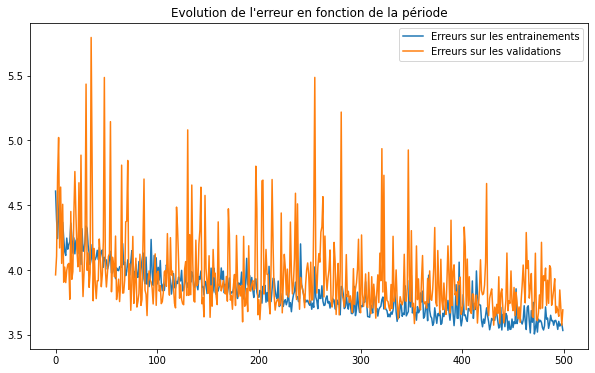

In [277]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

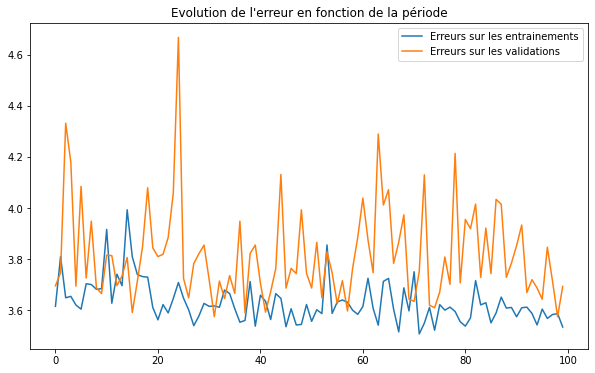

In [278]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_entrainement[400:500], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_validation[400:500], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**4. Prédictions**

Puisque le format d'entrée permet de prendre des séquences infinies, nous pouvons entrer des séquences de n'importe quelle taille :

In [279]:
# Charge les meilleurs poids
model.load_weights("poids.hdf5")

In [ ]:
X = np.reshape(serie[0:20],(1,20))
model.predict(X)

In [280]:
taille_fenetre = 20

# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(serie[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

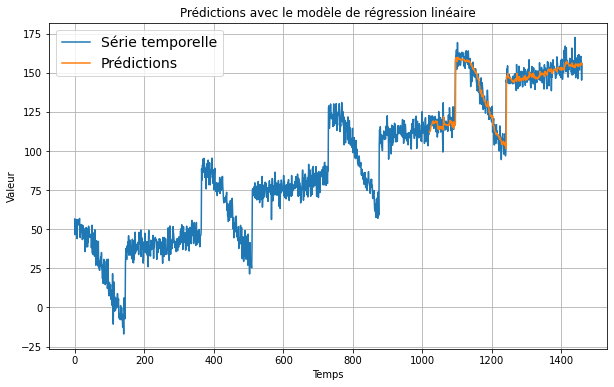

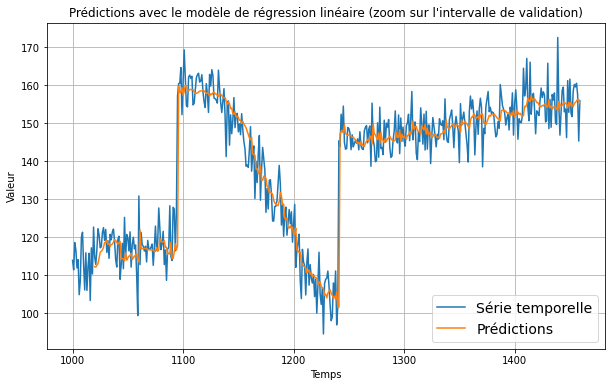

In [281]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle de régression linéaire')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle de régression linéaire (zoom sur l'intervalle de validation)")
plt.show()

In [282]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()

print(mae)
print(mse)

4.1586256
33.643925


# Création du modèle double couche LSTM

**1. Construction du modèle**

Sous forme de shéma, notre réseau est donc le suivant :

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/LSTM_2.png?raw=true" width="1200"> 

In [ ]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Fonction dela couche lambda de sortie
def Traitement_Sorties(x):
  return(x*100.0)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(None,)))
model.add(tf.keras.layers.Lambda(Traitement_Entrees))
model.add(tf.keras.layers.LSTM(40,return_sequences=True))
model.add(tf.keras.layers.LSTM(40))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Lambda(Traitement_Sorties))

model.save_weights('model_initial.h5')

model.summary()

**2. Optimisation du taux d'apprentissage**

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/20)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/20))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([taux[0], taux[99], 0, 100])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**3. Entrainement du modèle**

In [ ]:
# Remise à zéro des états du modèle
tf.keras.backend.clear_session()

# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=4e-6, momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset,validation_data=dataset_Val, epochs=500,verbose=1, callbacks=[CheckPoint])

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_entrainement[400:500], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_validation[400:500], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**4. Prédictions**

In [ ]:
# Charge les meilleurs poids
model.load_weights("poids.hdf5")

In [ ]:
taille_fenetre = 20

# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(serie[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

In [ ]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle de régression linéaire')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle de régression linéaire (zoom sur l'intervalle de validation)")
plt.show()

In [ ]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()

print(mae)
print(mse)

# Création du modèle double couche LSTM Bi-directionnel

**1. Construction du modèle**

In [ ]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Fonction dela couche lambda de sortie
def Traitement_Sorties(x):
  return(x*100.0)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(None,)))
model.add(tf.keras.layers.Lambda(Traitement_Entrees))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40)))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Lambda(Traitement_Sorties))

model.save_weights('model_initial.h5')

model.summary()

**2. Optimisation du taux d'apprentissage**

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([taux[0], taux[99], 0, 100])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**3. Entrainement du modèle**

In [ ]:
# Remise à zéro des états du modèle
tf.keras.backend.clear_session()

# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(lr=1e-3)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset,validation_data=dataset_Val, epochs=500,verbose=1, callbacks=[CheckPoint])

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_entrainement[400:500], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_validation[400:500], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**4. Prédictions**

In [ ]:
# Charge les meilleurs poids
model.load_weights("poids.hdf5")

In [ ]:
taille_fenetre = 20

# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(serie[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

In [ ]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle de régression linéaire')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle de régression linéaire (zoom sur l'intervalle de validation)")
plt.show()

In [ ]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()

print(mae)
print(mse)

In [ ]:
# Chargement des poids sauvegardés
model.load_weights("model_initial.h5")